# Plot a vertical cross section

We start from a CAM history file(s). Convert to pressure levels, and plot a cross section.

To make things more interesting, we will make plot showing temperature contours (color shading) and zonal wind speed (contour lines). We will extract the 1980s, and focus only on the Southern Hemisphere.

In [1]:
# libraries
from pathlib import Path 
import numpy as np
import xarray as xr
import Ngl
import matplotlib as mpl
import matplotlib.pyplot as plt

# libraries (from cesm-le-seaice-example.ipynb)
import os
from glob import glob
import cftime
from itertools import product, chain
import pandas as pd
import dask
import esmlab
from datetime import datetime as dt
ta=dt.now()

In [2]:
# it's probably worth taking a look at the versions
import sys
print(f"python version {sys.version}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"xarray version: {xr.__version__}")
print(f"PyNgl version: {Ngl.__version__}")

python version 3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 23:01:00) 
[GCC 7.3.0]
numpy version: 1.16.4
matplotlib version: 3.1.0
xarray version: 0.12.1
PyNgl version: 1.6.1


In [3]:
## spin up a dask cluster
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(4 * 9) # Ask for 4 x 9 workers
cluster

/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


The only hard part for making a pressure-latitude (or pressure by whatever) plot is to convert from the model's hybrid-sigma coordinate to a pressure coordinate. The following function, `use_vinth2p`, is one way to do this vertical interpolation. It uses PyNgl's `vinth2p` function, which is a thin wrapper around a 1-d interpolation routine written in Fortran.

In [4]:
## request
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://127.0.0.1:37316 Dashboard: http://127.0.0.1/proxy/8787/status,Cluster Workers: 9 Cores: 72 Memory: 67.30 GB


In [5]:
# The Ngl vertical interpolation is substantially faster than other python implementations,
# even though it is not as "pythonic" looking as some others.
def use_vinth2p(x_mdl, psfc, hya, hyb, pnew_hPa, p0=1000., interp=1, extrap=False):
    """Interpolate field x_mdl from hybrid levels to pressure levels given by pnew_hPa."""
    arr = Ngl.vinth2p(x_mdl, hya, hyb, pnew_hPa, psfc, interp, p0, 1, extrap)
    if arr is None:
        print(psfc)
    print(f"interpolation produces array of shape {arr.shape}")
    # wrap into xarray by making a new coordinate (plev) and put arr into DataArray
    plev = xr.DataArray(pnew_hPa, coords=[pnew_hPa], dims=['plev'], attrs={'units': 'hPa'})
    new_coords = []
    orig_coords = x_mdl.dims
    for c in orig_coords:
        if c == 'lev':
            new_coords.append((c, plev))
        else:
            new_coords.append((c, x_mdl[c]))
    Xp_xr = xr.DataArray(arr, coords=new_coords, attrs=x_mdl.attrs)
    Xp_xr.name = x_mdl.name
    return Xp_xr

## Data loading

Probably the 2nd hardest thing about this task is that we could be dealing with any number of possible permutations of the data. The most common cases are:
- native CAM history files (e.g., one-file-per-month with many variables)
- post-processed time series files (e.g., one or many files with one variable in each file)
- CMIP-like files, which are time series files that have been converted with CMIP variable names and other metadata.

In [6]:
# time series
# data_dir = Path("/glade/collections/cdg/timeseries-cmip6/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001/atm/proc/tseries/month_1")

# CAM history files
data_dir = Path("/glade/scratch/brianpm/archive/cesm2_f2000_default/atm/hist")

# data_dir = Path("/Volumes/project/amp/brianpm/aquadeck/qpc6_control/atm/hist")

# NOTE: Path is part of the standard library, and makes constructing and dealing with paths very easy.

In [7]:
# Native CAM history files:
# construct the ordered list of files:
fils = sorted(list(data_dir.glob('*.cam.h0.*.nc')))
ds = xr.open_mfdataset(fils, decode_cf=False)

# Time series files
# ds_rh = xr.open_dataset(data_dir + "/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.cam.h0.RELHUM.195001-201412.nc")
# d_p = xr.open_dataset(data_dir + "/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.cam.h0.PS.195001-201412.nc")

# CESM NOTE: The time is written at the END of the averaging period,
# so we need to correct the "time" coordinate so that the month doesn't think it is the next month
time_bnds = ds['time_bnds']
ds['time'].values = time_bnds.mean(dim='nbnd')
ds = xr.decode_cf(ds)

In [8]:
# maybe useful sometimes
variables = ["U", "T", "PS"]
var_arrs = {v: ds[v] for v in variables}
# allow lazy loading at this point, so should be fast.

In [9]:
hyam = ds['hyam'].isel(time=0).compute()
hybm = ds['hybm'].isel(time=0).compute()
# NOTE: We need to make sure that we make these 1-dimensional, or vinth2p may fail silently.

In [10]:
# spatial subset:
# should make the interpolation faster by reducing the array size first
# subset = {v: var_arrs[v].sel(time = slice('1980-01-01', '1989-12-01'), lat = slice(-90, 0)) for v in var_arrs}

# data dependent .... aquplanet doesn't have 1980s
subset = {v: var_arrs[v].sel(time = slice('0002-01-01', None), lat = slice(-90, 0)) for v in var_arrs}

In [11]:
# print(ds['time']) # this would be one month later if we didn't correct with time_bnds

In [12]:
# Define the pressure levels we want to use.
pnew = np.linspace(100, 1000, 19)  # hPa for vinth2p
print(pnew)

[ 100.  150.  200.  250.  300.  350.  400.  450.  500.  550.  600.  650.
  700.  750.  800.  850.  900.  950. 1000.]


In [13]:
%%time

# this is where we do the business
# keys that are the variable name
# values are the DataArray interpolated to pressure levels

# dictionary comprehension version
# on_p = {v: (use_vinth2p(v, subset["PS"], hyam, hybm, pnew)).squeeze() for v in ["U", "T"]}

# expanded version:
on_p = dict()
for v in ["U", "T"]:
    print(f"Working on variable: {v}")
    print(subset[v])
    on_p[v] = (use_vinth2p(subset[v], subset["PS"], hyam, hybm, pnew, p0=1000., interp=1, extrap=True)).squeeze()
    

Working on variable: U
<xarray.DataArray 'U' (time: 108, lev: 32, lat: 96, lon: 288)>
dask.array<shape=(108, 32, 96, 288), dtype=float32, chunksize=(1, 32, 96, 288)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... -2.356 -1.414 -0.4712
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0002-01-16 12:00:00 ... 0010-12-16 12:00:00
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Zonal wind
    cell_methods:  time: mean
interpolation produces array of shape (108, 19, 96, 288)
Working on variable: T
<xarray.DataArray 'T' (time: 108, lev: 32, lat: 96, lon: 288)>
dask.array<shape=(108, 32, 96, 288), dtype=float32, chunksize=(1, 32, 96, 288)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... -2.356 -1.414 -0.4712
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * l

In [14]:
%%time
# take the mean in time and longitude
answer = {v: on_p[v].mean(dim=('time','lon')) for v in on_p}

CPU times: user 644 ms, sys: 456 ms, total: 1.1 s
Wall time: 900 ms


# Plot
 
We now have the variables interpolated to pressure levels. All we need to do is plot what we want.

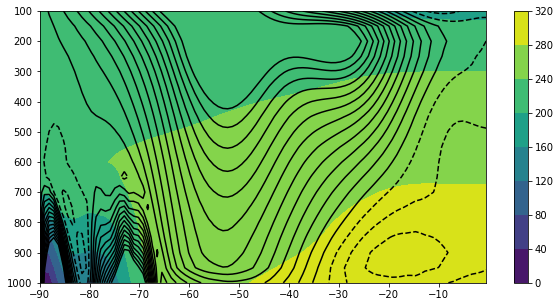

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
lats, levs = np.meshgrid(answer['T']['lat'], answer['T']['lev'])
im = ax.contourf(lats, levs, answer['T'])
wind = ax.contour(lats, levs, answer['U'], levels=np.linspace(-25, 25, 26), colors='black')
ax.invert_yaxis()
fig.colorbar(im)

## Nothing's ever that easy
The interpolation doesn't seem to handle missing data correctly in this instance. Turning on the extrapolation at least provides some "reasonable" values, but we typically do not want to have values that are under Antarctica's surface. We can go back to the interpolated data and mask any values that are below the actual surface pressure, and then compare the resulting plot.

In [16]:
# but let's try to remove the spurious points
t_tmp = on_p['T']
u_tmp = on_p['U']
for k, level in enumerate(pnew):
    t_tmp[:,k,:,:] = np.where(subset['PS']/100. < level, np.nan, t_tmp[:,k,:,:])
    u_tmp[:,k,:,:] = np.where(subset['PS']/100. < level, np.nan, u_tmp[:,k,:,:])
    

/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


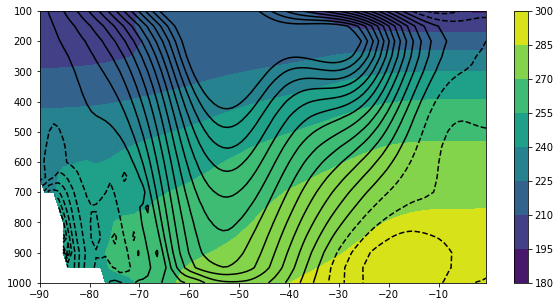

In [17]:
fig2, ax2 = plt.subplots(figsize=(10,5))
im2 = ax2.contourf(lats, levs, t_tmp.mean(dim=('time','lon')))
wind2 = ax2.contour(lats, levs, u_tmp.mean(dim=('time','lon')), levels=np.linspace(-25, 25, 26), colors='black')
ax2.invert_yaxis()
fig2.colorbar(im2)

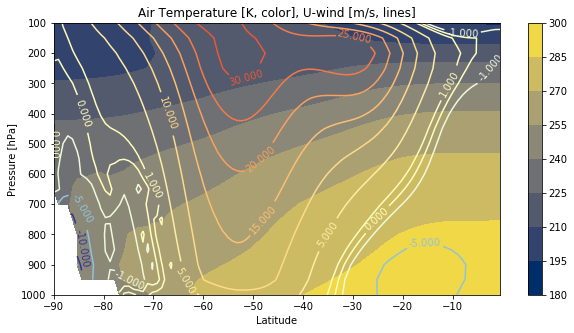

In [18]:
# cosmetics
fig2, ax2 = plt.subplots(figsize=(10,5))
im2 = ax2.contourf(lats, levs, t_tmp.mean(dim=('time','lon')), cmap='cividis')

divnorm = mpl.colors.DivergingNorm(vmin=-10., vcenter=0, vmax=45.)


wind2 = ax2.contour(lats, levs, u_tmp.mean(dim=('time','lon')), 
                    levels=[-10, -5, -1, 0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45], 
                    norm=divnorm, cmap='RdYlBu_r')
ax2.invert_yaxis()
ax2.set_title("Air Temperature [K, color], U-wind [m/s, lines]")
ax2.set_xlabel("Latitude")
ax2.set_ylabel("Pressure [hPa]")
ax2.clabel(wind2, inline=1, fontsize=10)
fig2.colorbar(im2)

In [19]:
totaltime=dt.now()-ta
print(totaltime)

0:00:54.692268


In [20]:
cluster.close()
client.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/tornado/gen.py", line 965, in with_timeout
    chain_future(future, result)
  File "/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/tornado/concurrent.py", line 611, in chain_future
    future_add_done_callback(a, copy)
  File "/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/tornado/concurrent.py", line 658, in future_add_done_callback
    callback(future)
  File "/